# Peruvian Expected Interest Rate

## <a> Outline </a>
- <a href='#model'> Model </a>
- <a href='#lib'> Libraries </a>
- <a href='#data'> Data Collection </a>
- <a href='#ref'>References</a>

## <a id='model'> Model </a>

For the estimation of the expected interest rate we are going to use the Taylor Rule adjusted to the Peruvian Economy, following Winkelried (2013, in <a href='#vega'>Vega 2019</a>)

$$i_{t} = \rho i_{t-1} + (1-\rho)[i^{*}+\phi_{\pi}(\pi^{e}_{t} - \bar{\pi}) + \phi_{y}(y_{t}-\bar{y}_{t})
]$$

where
- $i_{t}$ is the interest rate.
- $i_{t-1}$ is the lagged interest rate, used as inertial component.
- $i^{*}$ is the natural interest rate.
- $\pi^{e}_{t}$ is the expected inflation rate.
- $\bar{\pi}$ is the inflation target.
- $y_{t}$ is the GDP.
- $\bar{y}_{t}$ is the potential GDP.

with the following parameter calibration

| Paramether | Monthly | Quarterly |
| --- | --- | --- |
| $\rho$ | 0.89 | 0.7 |
| $\phi_{\pi}$ | 1.5 | 1.5 |
| $\phi_{y}$ | 0.5 | 0.5 |
| $i^{*}$ | 1.8 | 1.8 |

## <a id='lib'> Libraries </a>

In [1]:
import requests


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


from statsmodels.tsa.filters.hp_filter import hpfilter

## <a id='data'> Data Collection </a>

In [2]:
## Basic parameters
url_base="https://estadisticas.bcrp.gob.pe/estadisticas/series/api/"
formato="/json"
per="/2003-9/2022-2"

## List of variables
series_list = ["PD12912AM", # Inflation Expectation to 12 months
               "PD04722MM", # Monetary Policy Reference Rate
               "PN38081AM" # 3 months Seasonally adjusted GDP (index 2007=100)
              ]

## Empty dictionaries
url = {}
ans = {}
dfs = {}

## Loop to get variables from BCRP Request
for i in range(len(series_list)):
    url[series_list[i]] = url_base+series_list[i]+formato+per
    ans[series_list[i]] = requests.get(url[series_list[i]])
    dfs[series_list[i]] = pd.DataFrame(ans[series_list[i]].json()["periods"])
    dfs[series_list[i]]["values"] = dfs[series_list[i]]["values"].str[0].astype(float)
    
dates = dfs[series_list[i]]["name"]

df = pd.concat([dates,
                dfs["PD12912AM"]["values"],
                dfs["PD04722MM"]["values"],
                dfs["PN38081AM"]["values"]],
               axis=1,
               keys=['dates', 'inflation_e', 'mon_rate', 'gdp'])

## getting GDP cycle for GDP gap
df["gdp"] = np.log(df["gdp"])
gdp_cycle, gdp_trend = hpfilter(df['gdp'], lamb=14400)
df["gdp_gap"] = gdp_cycle*100

## getting expected inflation vs target
df["inflation_tar"] = 2.5 
df["inflation_tar"][10:] = 2
df["inflation_gap"] = df["inflation_e"] - df["inflation_tar"]

## Final data
var_list = ['dates', 'inflation_gap', 'mon_rate', 'gdp_gap']
data = df[var_list]

D:\Users\jose.gallardoa\AppData\Local\Temp/ipykernel_15592/2871333246.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["inflation_tar"][10:] = 2


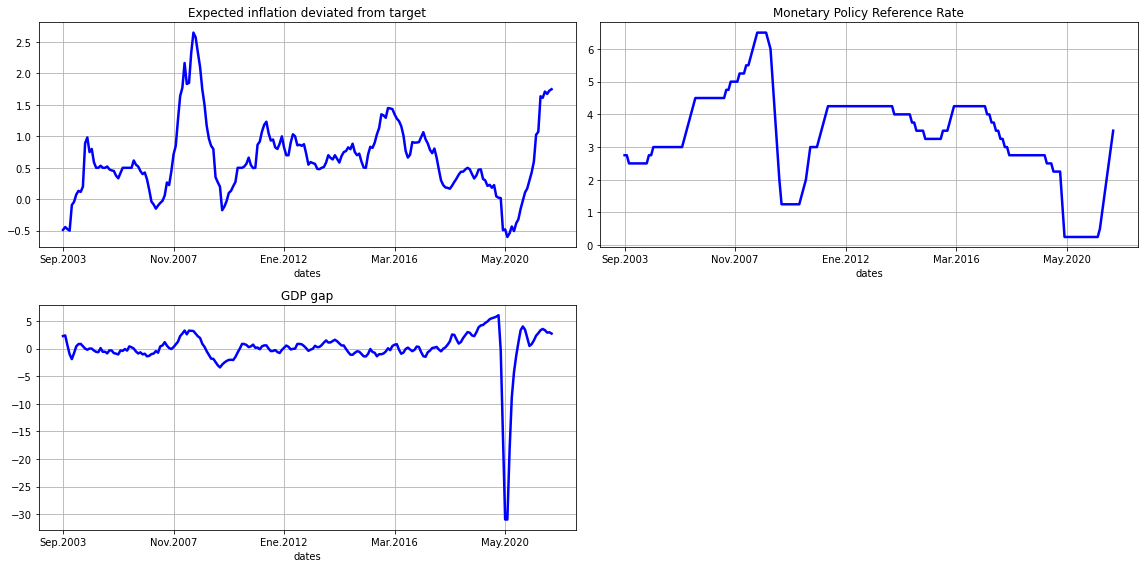

In [3]:
fig, axis = plt.subplots(nrows = 2,
                         ncols = 2,
                         figsize = (16,8))

var_names = ["Expected inflation deviated from target",
         "Monetary Policy Reference Rate",
         "GDP gap"]

# Loop for subplot
idx = 1

for i in range(2):
    for j in range (2):
        
        # if idx is minor to number of elements
        if idx <= len(var_list) - 1:
            ax = axis[i][j]
            data.plot(x = "dates",
                        y = var_list[idx],
                        ax = ax,
                        color = 'blue',
                        linewidth=2.5,
                        legend = False)
            
            ax.set_title(var_names[idx-1])
            ax.grid(which='major')
            idx = idx + 1
            
        # if idx is major to number of elements        
        else:        
            axis[i,j].axis('off')
            idx = idx + 1
            
fig.tight_layout()

plt.savefig(r".\images\er_variables.png", bbox_inches='tight')
plt.savefig(r".\images\er_variables.eps", bbox_inches='tight')

In [4]:
data.loc[0,"expected_rate"] = data.loc[0,"mon_rate"]
ρ = 0.89
i_star = 1.8

for t in range(0,len(data)-1):
    data["expected_rate"][t+1] = ρ*data["mon_rate"][t] + (1-ρ)*(i_star + 1.5*data["inflation_gap"][t+1] + 0.5*data["gdp_gap"][t+1])

D:\Users\jose.gallardoa\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
D:\Users\jose.gallardoa\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
D:\Users\jose.gallardoa\AppData\Local\Temp/ipykernel_15592/2215368899.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

In [5]:
var_list_2 = ['dates', 'mon_rate', 'expected_rate']
rates = data[var_list_2]

var_names_2 = ["Monetary Policy Reference Rate",
            "Expected Interest Rate"]


<AxesSubplot:>

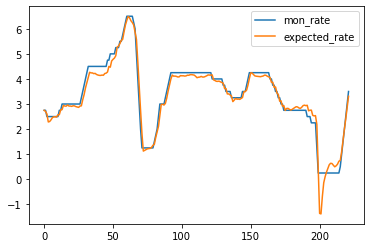

In [6]:
rates.plot()

D:\Users\jose.gallardoa\AppData\Local\Temp/ipykernel_15592/3029343247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rates["gap"] = rates["mon_rate"] - rates["expected_rate"]


<AxesSubplot:>

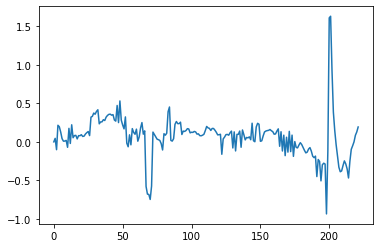

In [7]:
rates["gap"] = rates["mon_rate"] - rates["expected_rate"]
rates["gap"].plot()

In [8]:
rates.to_excel(r".\data\E(r)_result.xlsx", index = False)

## <a id='ref'>References</a>

<a id='vega'> Hugo Vega 2019 </a>. ["Perú | ¿Qué hará el Banco Central con su tasa de política en los próximos meses?"](https://www.bbvaresearch.com/wp-content/uploads/2019/04/Observatorio-Regla-Taylor-Peru-2019-2.pdf) BBVA Research, Análisis Macroeconómico.

<a id='vega'> BCRP 2017 </a>. ["Re-estimación de la tasa de interés neutral"](https://www.bcrp.gob.pe/docs/Publicaciones/Reporte-Inflacion/2017/setiembre/ri-setiembre-2017-recuadro-2.pdf) Recuadros del reporte de inflación.
